In [1]:
# NBVAL_SKIP
import os
#os.environ['SPS_HOME'] = '/mnt/storage/annalena_data/sps_fsps'
#os.environ['SPS_HOME'] = '/home/annalena/sps_fsps'
os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'

In [2]:
# NBVAL_SKIP
import logging

# Disable all logging messages
#logging.disable(logging.CRITICAL)

# Load ssp template from FSPS

In [3]:
# NBVAL_SKIP
from rubix.spectra.ssp.factory import get_ssp_template
ssp_fsps = get_ssp_template("FSPS")

2025-05-25 21:10:24,794 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-05-25 21:10:24,794 - rubix - INFO - Rubix version: 0.0.post400+gee789d5.d20250306
2025-05-25 21:10:24,794 - rubix - INFO - JAX version: 0.5.0
2025-05-25 21:10:24,803 - rubix - INFO - Running on [CpuDevice(id=0)] devices


In [4]:
# NBVAL_SKIP
age_values = ssp_fsps.age
print(age_values.shape)

metallicity_values = ssp_fsps.metallicity
print(metallicity_values.shape)

(107,)
(12,)


In [5]:
# NBVAL_SKIP
index_age = 90
index_metallicity = 9

#initial_metallicity_index = 5
#initial_age_index = 70
initial_metallicity_index = 10
initial_age_index = 104

learning_all = 1e-2
tol = 1e-10

print(f"start age: {age_values[initial_age_index]}, start metallicity: {metallicity_values[initial_metallicity_index]}")
print(f"target age: {age_values[index_age]}, target metallicity: {metallicity_values[index_metallicity]}")

start age: 15.848933219909668, start metallicity: 0.025251565501093864
target age: 3.1622776985168457, target metallicity: 0.014199999161064625


# Configure pipeline

In [6]:
# NBVAL_SKIP
from rubix.core.pipeline import RubixPipeline
import os
config = {
    "pipeline":{"name": "calc_gradient"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 2,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "TESTGRADIENT",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 1.2},
         "noise": {"signal_to_noise": 100,"noise_distribution": "normal"},
         },
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "FSPS"
        },
        "dust": {
                "extinction_model": "Cardelli89",
                "dust_to_gas_ratio": 0.01,
                "dust_to_metals_ratio": 0.4,
                "dust_grain_density": 3.5,
                "Rv": 3.1,
            },
    },        
}

In [7]:
# NBVAL_SKIP
pipe = RubixPipeline(config)
inputdata = pipe.prepare_data()
rubixdata = pipe.run(inputdata)

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-05-25 21:10:25,347 - rubix - INFO - Getting rubix data...
2025-05-25 21:10:25,347 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
/Users/annalena/miniconda3/envs/rubix/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/Users/annalena/Documents/GitHub/rubix/rubix/core/data.py:535: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and wil

# Set target values

In [8]:
# NBVAL_SKIP
import jax.numpy as jnp

rubixdata.stars.age = jnp.array([age_values[index_age-8], age_values[index_age]])
rubixdata.stars.metallicity = jnp.array([metallicity_values[index_metallicity-1], metallicity_values[index_metallicity]])
rubixdata.stars.mass = jnp.array([[1.0, 1.0]])
rubixdata.stars.velocity = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
rubixdata.stars.coords = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

In [9]:
# NBVAL_SKIP
targetdata = pipe.run(rubixdata)

2025-05-25 21:10:27,868 - rubix - INFO - Setting up the pipeline...
2025-05-25 21:10:27,869 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'scale_spectrum_by_mass', 'args': [], 'kwargs': {}}, 'calculate_datacube': {'name': 'calculate_datacube', 'depends_on': 'doppler_shift_and_resampling', 'args': [], 'kwargs': {}}, 'convolve_psf': {'name': 'convolve_psf', 'depends

# Set initial datracube

In [10]:
# NBVAL_SKIP
rubixdata.stars.age = jnp.array([age_values[initial_age_index+1], age_values[initial_age_index]])
rubixdata.stars.metallicity = jnp.array([metallicity_values[initial_metallicity_index-2], metallicity_values[initial_metallicity_index]])
rubixdata.stars.mass = jnp.array([[1.0, 1.0]])
rubixdata.stars.velocity = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
rubixdata.stars.coords = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

In [11]:
# NBVAL_SKIP
initialdata = pipe.run(rubixdata)

2025-05-25 21:10:29,174 - rubix - INFO - Setting up the pipeline...
2025-05-25 21:10:29,175 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'scale_spectrum_by_mass', 'args': [], 'kwargs': {}}, 'calculate_datacube': {'name': 'calculate_datacube', 'depends_on': 'doppler_shift_and_resampling', 'args': [], 'kwargs': {}}, 'convolve_psf': {'name': 'convolve_psf', 'depends

# Adam optimizer

In [12]:
# NBVAL_SKIP
from rubix.pipeline import linear_pipeline as pipeline

pipeline_instance = RubixPipeline(config)

pipeline_instance._pipeline = pipeline.LinearTransformerPipeline(
    pipeline_instance.pipeline_config, 
    pipeline_instance._get_pipeline_functions()
)
pipeline_instance._pipeline.assemble()
pipeline_instance.func = pipeline_instance._pipeline.compile_expression()

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-05-25 21:10:30,512 - rubix - INFO - Setting up the pipeline...
2025-05-25 21:10:30,512 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

In [13]:
# NBVAL_SKIP
import optax

def loss_only_wrt_age_metallicity(age, metallicity, base_data, target):
        
        base_data.stars.age = age*20
        base_data.stars.metallicity = metallicity*0.05

        output = pipeline_instance.func(base_data)
        #loss = jnp.sum((output.stars.datacube - target.stars.datacube) ** 2)
        #loss = jnp.sum(optax.l2_loss(output.stars.datacube, target.stars.datacube))
        #loss = jnp.sum(optax.huber_loss(output.stars.datacube, target.stars.datacube))
        loss = jnp.sum(optax.cosine_distance(output.stars.datacube, target.stars.datacube))
        
        return jnp.log10(loss) #loss#/0.03 #jnp.log10(loss #/5e-5)



In [14]:
# NBVAL_SKIP

# Define your target learning rate and the number of warmup steps.
target_lr_age = 0.5
warmup_steps = 200
# Create a warmup schedule that linearly increases from 0 to target_lr.
warmup_schedule_age = optax.linear_schedule(
    init_value=1e-50,
    end_value=target_lr_age,
    transition_steps=warmup_steps
)
# After warmup, use a constant schedule at target_lr.
constant_schedule_age = optax.constant_schedule(target_lr_age)
# Combine the schedules:
schedule_fn_age = optax.join_schedules(
    schedules=[warmup_schedule_age, constant_schedule_age],
    boundaries=[warmup_steps]
)


target_lr_metallicity = 1e-4
# Create a warmup schedule that linearly increases from 0 to target_lr.
warmup_schedule_metallicity = optax.linear_schedule(
    init_value=1e-5,
    end_value=target_lr_metallicity,
    transition_steps=warmup_steps
)
# After warmup, use a constant schedule at target_lr.
constant_schedule_metallicity = optax.constant_schedule(target_lr_metallicity)
# Combine the schedules:
schedule_fn_metallicity = optax.join_schedules(
    schedules=[warmup_schedule_metallicity, constant_schedule_metallicity],
    boundaries=[warmup_steps]
)

In [15]:
# NBVAL_SKIP
import jax
import jax.numpy as jnp
import optax


def adam_optimization_multi(loss_fn, params_init, data, target, learning=learning_all, tol=1e-3, max_iter=500):
    """
    Optimizes both age and metallicity.

    Args:
        loss_fn: function with signature loss_fn(age, metallicity, data, target)
        params_init: dict with keys 'age' and 'metallicity', each a JAX array
        data: base data for the loss function
        target: target data for the loss function
        learning_rate: learning rate for Adam
        tol: tolerance for convergence (based on update norm)
        max_iter: maximum number of iterations

    Returns:
        params: final parameters (dict)
        params_history: list of parameter values for each iteration
        loss_history: list of loss values for each iteration
    """
    params = params_init  # e.g., {'age': jnp.array(...), 'metallicity': jnp.array(...)}
    optimizers = {
        'age': optax.adam(learning),
        'metallicity': optax.adam(learning)
        #'age': optax.adam(learning_rate=schedule_fn_age),
        #'metallicity': optax.adam(learning_rate=schedule_fn_metallicity)
    }
    # Create a parameter label pytree matching the structure of params
    param_labels = {'age': 'age', 'metallicity': 'metallicity'}
    
    # Combine the optimizers with multi_transform
    optimizer = optax.multi_transform(optimizers, param_labels)
    optimizer_state = optimizer.init(params)
    
    age_history1 = []
    age_history2 = []
    metallicity_history1 = []
    metallicity_history2 = []
    loss_history = []
    
    for i in range(max_iter):
        # Compute loss and gradients with respect to both parameters
        loss, grads = jax.value_and_grad(lambda p: loss_fn(p['age'], p['metallicity'], data, target))(params)
        loss_history.append(float(loss))
        # Save current parameters (convert from JAX arrays to floats)
        age_history1.append(float(params['age'][0]))
        age_history2.append(float(params['age'][1]))
        metallicity_history1.append(float(params['metallicity'][0]))
        metallicity_history2.append(float(params['metallicity'][1]))
        #params_history.append({
        #    'age': params['age'],
        #    'metallicity': params['metallicity']
        #})
        
        # Compute updates and apply them
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        params = optax.apply_updates(params, updates)
        
        # Optionally clip the parameters to enforce physical constraints:
        #params['age'] = jnp.clip(params['age'], 0.0, 1.0)
        #params['metallicity'] = jnp.clip(params['metallicity'], 0.0, 1.0)
        # For metallicity, uncomment and adjust the limits as needed:
        # params['metallicity'] = jnp.clip(params['metallicity'], metallicity_lower_bound, metallicity_upper_bound)
        
        # Check convergence based on the global norm of updates
        if optax.global_norm(updates) < tol:
            print(f"Converged at iteration {i}")
            break

    return params, age_history1, age_history2, metallicity_history1, metallicity_history2, loss_history

In [16]:
# NBVAL_SKIP
pipe.loss_only_wrt_age_metallicity(inputdata.stars.age, inputdata.stars.metallicity, inputdata, targetdata)

2025-05-25 21:10:30,736 - rubix - INFO - Setting up the pipeline...
2025-05-25 21:10:30,736 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'scale_spectrum_by_mass', 'args': [], 'kwargs': {}}, 'calculate_datacube': {'name': 'calculate_datacube', 'depends_on': 'doppler_shift_and_resampling', 'args': [], 'kwargs': {}}, 'convolve_psf': {'name': 'convolve_psf', 'depends

Array(1492.1357, dtype=float32)

In [ ]:
# NBVAL_SKIP
data = initialdata  # Replace with your actual data if needed
target_value = targetdata  # Replace with your actual target

# Define initial guesses for both age and metallicity.
# Adjust the initialization as needed for your problem.
age_init = jnp.array([age_values[initial_age_index+1]/20, age_values[initial_age_index]/20])
metallicity_init = jnp.array([metallicity_values[initial_metallicity_index-2]/0.05, metallicity_values[initial_metallicity_index]/0.05])


# Pack both initial parameters into a dictionary.
params_init = {'age': age_init, 'metallicity': metallicity_init}
print(f"Initial parameters: {params_init}")

# Call the new optimizer function that handles both parameters.
optimized_params, age_history1, age_history2, metallicity_history1, metallicity_history2, loss_history = adam_optimization_multi(
    loss_only_wrt_age_metallicity,
    params_init,
    data,
    target_value,
    learning=learning_all,
    tol=tol,
    max_iter=5000,
)

print(f"Optimized Age: {optimized_params['age']}")
print(f"Optimized Metallicity: {optimized_params['metallicity']}")

2025-05-25 21:10:32,177 - rubix - INFO - Rotating galaxy with alpha=90.0, beta=0.0, gamma=0.0
2025-05-25 21:10:32,178 - rubix - INFO - Rotating galaxy for simulation: IllustrisTNG
2025-05-25 21:10:32,178 - rubix - WARNING - Gas not found in particle_type, only rotating stellar component.
2025-05-25 21:10:32,202 - rubix - INFO - Assigning particles to spaxels...
2025-05-25 21:10:32,203 - rubix - WARNING - Attribute value of mask is None or not an array
2025-05-25 21:10:32,204 - rubix - WARNING - Attribute value of tree_flatten is None or not an array
2025-05-25 21:10:32,204 - rubix - WARNING - Attribute value of tree_unflatten is None or not an array
2025-05-25 21:10:32,204 - rubix - INFO - Calculating IFU cube...
2025-05-25 21:10:32,204 - rubix - DEBUG - Input shapes: Metallicity: 1, Age: 1
2025-05-25 21:10:32,281 - rubix - DEBUG - Calculation Finished! Spectra shape: (1, 2, 5994)
2025-05-25 21:10:32,281 - rubix - INFO - Scaling Spectra by Mass...
2025-05-25 21:10:32,282 - rubix - INFO

Initial parameters: {'age': Array([0.8891398, 0.7924467], dtype=float32), 'metallicity': Array([0.15970497, 0.5050313 ], dtype=float32)}
Optimized Age: [0.6318859  0.10143121]
Optimized Metallicity: [-0.09427519  0.13208623]


## Loss history

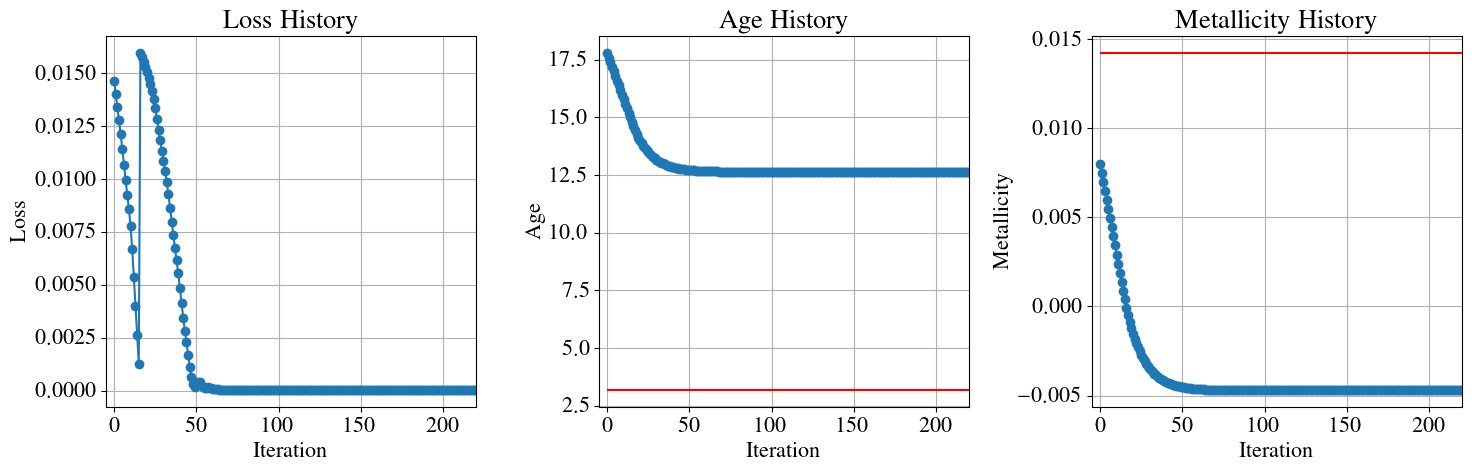

In [18]:
# NBVAL_SKIP
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib to use LaTeX for all text
mpl.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text rendering
    "font.family": "serif",             # Use serif fonts
    # Here "txfonts" is not directly available as a font in matplotlib,
    # but you can set the serif list to a font that closely resembles it.
    # Alternatively, you can try using:
    "font.serif": ["Times", "Palatino", "New Century Schoolbook"],
    "font.size": 16,                    # Set the base font size (adjust to match your document)
    "text.latex.preamble": r"\usepackage{txfonts}",  # Use txfonts to match your Overleaf document
})


# Convert histories to NumPy arrays if needed
loss_history_np = np.array(loss_history)
age_history_np = np.array(age_history1)
metallicity_history_np = np.array(metallicity_history1)

# Create an x-axis based on the number of iterations (assumed same for all)
iterations = np.arange(len(loss_history_np))

# Create a figure with three subplots in one row and shared x-axis.
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Plot the loss history (convert log-loss back to loss if needed)
axs[0].plot(iterations, 10**loss_history_np, marker='o', linestyle='-')
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss History")
axs[0].grid(True)

# Plot the age history, multiplying by 20 for the physical scale.
axs[1].plot(iterations, age_history_np * 20, marker='o', linestyle='-')
# Draw a horizontal line for the target age
axs[1].hlines(y=age_values[index_age], xmin=0, xmax=iterations[-1], color='r', linestyle='-')
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Age")
axs[1].set_title("Age History")
axs[1].grid(True)

# Plot the metallicity history, multiplying by 0.05 for the physical scale.
axs[2].plot(iterations, metallicity_history_np * 0.05, marker='o', linestyle='-')
# Draw a horizontal line for the target metallicity
axs[2].hlines(y=metallicity_values[index_metallicity], xmin=0, xmax=iterations[-1], color='r', linestyle='-')
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Metallicity")
axs[2].set_title("Metallicity History")
axs[2].grid(True)

axs[0].set_xlim(-5, 220)
axs[1].set_xlim(-5, 220)
axs[2].set_xlim(-5, 220)
plt.tight_layout()
plt.savefig(f"output/optimisation_history.jpg", dpi=1000)
plt.show()


/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-05-25 21:13:21,536 - rubix - INFO - Setting up the pipeline...
2025-05-25 21:13:21,537 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

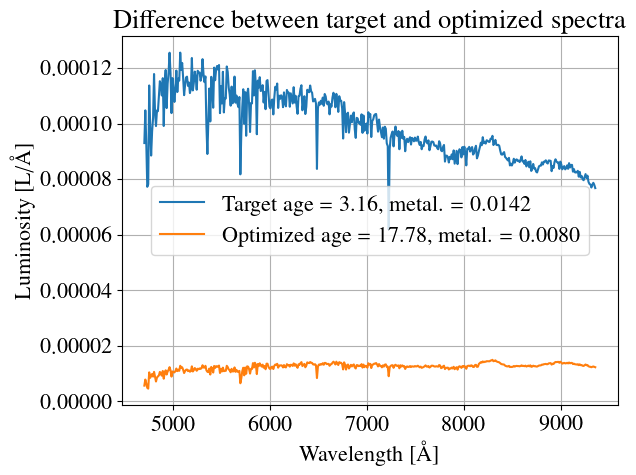

In [20]:
# NBVAL_SKIP
#run the pipeline with the optimized age
#rubixdata.stars.age = optimized_age
i = 0
rubixdata.stars.age = jnp.array([age_history1[i]*20, age_histor2[i]*20])
rubixdata.stars.metallicity = jnp.array([metallicity_history1[i]*0.05, metallicity_history2[i]*0.05])
rubixdata.stars.mass = jnp.array([[1.0, 1.0]])
rubixdata.stars.velocity = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

pipe = RubixPipeline(config)
rubixdata = pipe.run(rubixdata)

#plot the target and the optimized spectra
import matplotlib.pyplot as plt
wave = pipe.telescope.wave_seq

spectra_target = targetdata.stars.datacube
spectra_optimitzed = rubixdata.stars.datacube

plt.plot(wave, spectra_target[0,0,:], label=f"Target age = {age_values[index_age]:.2f}, metal. = {metallicity_values[index_metallicity]:.4f}")
plt.plot(wave, spectra_optimitzed[0,0,:], label=f"Optimized age = {age_history1[i]*20:.2f}, metal. = {metallicity_history1[i]*0.05:.4f}")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Luminosity [L/Å]")
plt.title("Difference between target and optimized spectra")
#plt.title(f"Loss {loss_history[i]:.2e}")
plt.legend()
#plt.ylim(0.00003, 0.00008)
plt.grid(True)
plt.show()

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-05-25 20:58:32,451 - rubix - INFO - Setting up the pipeline...
2025-05-25 20:58:32,451 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

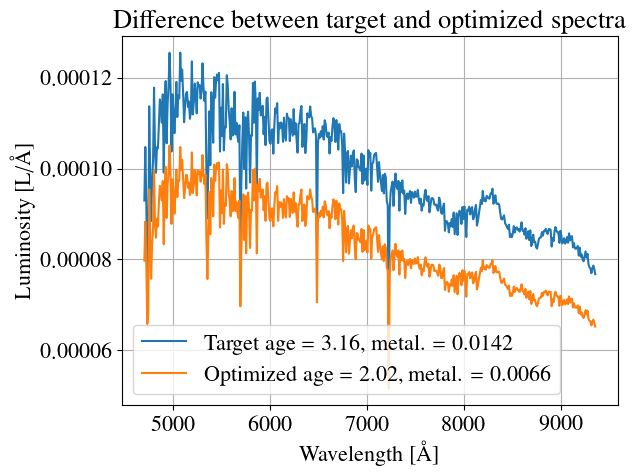

In [ ]:
# NBVAL_SKIP
#run the pipeline with the optimized age
#rubixdata.stars.age = optimized_age
i = 208
rubixdata.stars.age = jnp.array([age_history[i]*20, age_history[i]*20])
rubixdata.stars.metallicity = jnp.array([metallicity_history[i]*0.05, metallicity_history[i]*0.05])
rubixdata.stars.mass = jnp.array([[1.0, 1.0]])
rubixdata.stars.velocity = jnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])

pipe = RubixPipeline(config)
rubixdata = pipe.run(rubixdata)

#plot the target and the optimized spectra
import matplotlib.pyplot as plt
wave = pipe.telescope.wave_seq

spectra_target = targetdata.stars.datacube
spectra_optimitzed = rubixdata.stars.datacube

plt.plot(wave, spectra_target[0,0,:], label=f"Target age = {age_values[index_age]:.2f}, metal. = {metallicity_values[index_metallicity]:.4f}")
plt.plot(wave, spectra_optimitzed[0,0,:], label=f"Optimized age = {age_history[i]*20:.2f}, metal. = {metallicity_history[i]*0.05:.4f}")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Luminosity [L/Å]")
plt.title("Difference between target and optimized spectra")
#plt.title(f"Loss {loss_history[i]:.2e}")
plt.legend()
#plt.ylim(0.00003, 0.00008)
plt.grid(True)
plt.show()

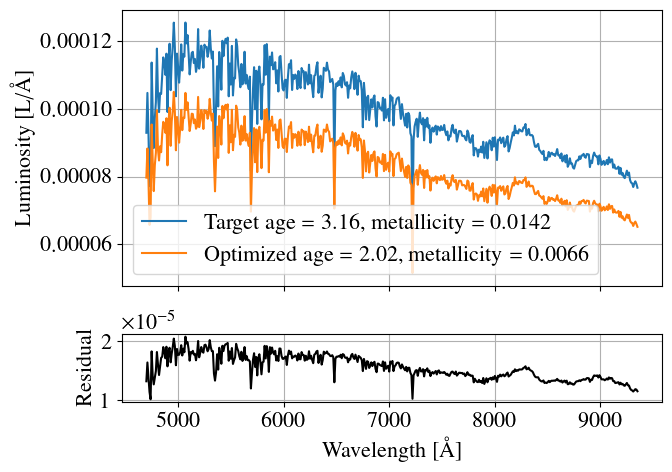

In [ ]:
# NBVAL_SKIP
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create a figure with two subplots, sharing the x-axis.
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1]}, figsize=(7, 5))

# Plot target and optimized spectra in the upper subplot.
ax1.plot(wave, spectra_target[0, 0, :], label=f"Target age = {age_values[index_age]:.2f}, metallicity = {metallicity_values[index_metallicity]:.4f}")
ax1.plot(wave, spectra_optimitzed[0, 0, :], label=f"Optimized age = {age_history[i]*20:.2f}, metallicity = {metallicity_history[i]*0.05:.4f}")
ax1.set_ylabel("Luminosity [L/Å]")
#ax1.set_title("Target vs Optimized Spectra")
ax1.legend()
ax1.grid(True)

# Compute the residual (difference between target and optimized spectra).
residual = (spectra_target[0, 0, :] - spectra_optimitzed[0, 0, :]) #/spectra_target[0, 0, :]

# Plot the residual in the lower subplot.
ax2.plot(wave, residual, 'k-')
ax2.set_xlabel("Wavelength [Å]")
ax2.set_ylabel("Residual")
ax2.grid(True)

plt.tight_layout()
plt.savefig(f"output/optimisation_spectra.jpg", dpi=1000)
plt.show()


# Calculate loss landscape

In [ ]:
# NBVAL_SKIP
import optax

def loss_only_wrt_age_metallicity(age, metallicity, base_data, target):

    # Create 2D arrays for age and metallicity.
    # For example, if there are two stars, you might do:
    base_data.stars.age = jnp.array([[age*20, age*20]])
    base_data.stars.metallicity = jnp.array([[metallicity*0.05, metallicity*0.05]])

    output = pipeline_instance.func(base_data)
    #loss = jnp.sum((output.stars.datacube - target.stars.datacube) ** 2)
    loss = jnp.sum(optax.cosine_distance(output.stars.datacube, target.stars.datacube))
    return loss


In [ ]:
# NBVAL_SKIP
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Number of grid points
num_steps = 100

# Define physical ranges
physical_ages = jnp.linspace(0, 1, num_steps)         # Age from 0 to 10
physical_metals = jnp.linspace(0, 1, num_steps)    # Metallicity from 1e-4 to 0.05

# Use nested vmap to compute the loss at every grid point.
# Note: loss_only_wrt_age_metallicity takes physical values directly.
vectorized_loss = jax.vmap(
    lambda age: jax.vmap(
        lambda metal: loss_only_wrt_age_metallicity(age, metal, inputdata, targetdata)
    )(physical_metals)
)(physical_ages)

# Convert the result to a NumPy array for plotting
loss_map = jnp.array(vectorized_loss)


2025-05-25 20:58:35,208 - rubix - INFO - Rotating galaxy with alpha=90.0, beta=0.0, gamma=0.0
2025-05-25 20:58:35,209 - rubix - INFO - Rotating galaxy for simulation: IllustrisTNG
2025-05-25 20:58:35,209 - rubix - WARNING - Gas not found in particle_type, only rotating stellar component.
2025-05-25 20:58:35,233 - rubix - INFO - Assigning particles to spaxels...
2025-05-25 20:58:35,234 - rubix - WARNING - Attribute value of datacube is None or not an array
2025-05-25 20:58:35,234 - rubix - WARNING - Attribute value of mask is None or not an array
2025-05-25 20:58:35,235 - rubix - WARNING - Attribute value of spectra is None or not an array
2025-05-25 20:58:35,235 - rubix - WARNING - Attribute value of tree_flatten is None or not an array
2025-05-25 20:58:35,236 - rubix - WARNING - Attribute value of tree_unflatten is None or not an array
2025-05-25 20:58:35,236 - rubix - INFO - Calculating IFU cube...
2025-05-25 20:58:35,236 - rubix - DEBUG - Input shapes: Metallicity: 1, Age: 1
2025-05

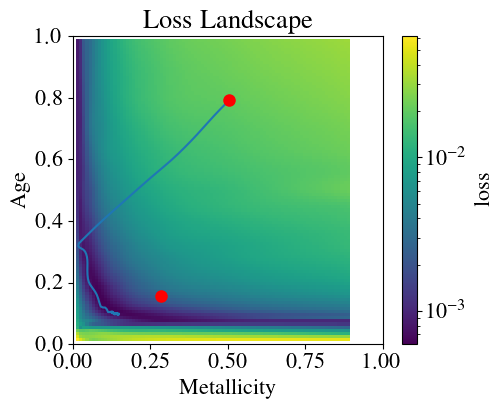

In [ ]:
# NBVAL_SKIP
# Plot the loss landscape using imshow.
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(5, 4))
plt.imshow(loss_map, origin='lower', extent=[0,1,0,1], aspect='auto', norm=colors.LogNorm())#, vmin=-3.5, vmax=-2.5)#extent=[1e-4, 0.05, 0, 10]
plt.xlabel('Metallicity')
plt.ylabel('Age')
plt.title('Loss Landscape')
plt.colorbar(label='loss')
# Plot a red dot at the desired coordinates.
plt.plot(metallicity_history[:], age_history[:])#, 'bx', markersize=8)
#plt.plot(metallicity_history[::100], age_history[::100], 'bx', markersize=8)
plt.plot(metallicity_values[index_metallicity]/0.05, age_values[index_age]/20, 'ro', markersize=8)
plt.plot(metallicity_values[initial_metallicity_index]/0.05, age_values[initial_age_index]/20, 'ro', markersize=8)
plt.savefig(f"output/optimisation_losslandscape.jpg", dpi=1000)
plt.show()


In [ ]:
metallicity_history = np.array(metallicity_history)*0.05
age_history = np.array(age_history)*20

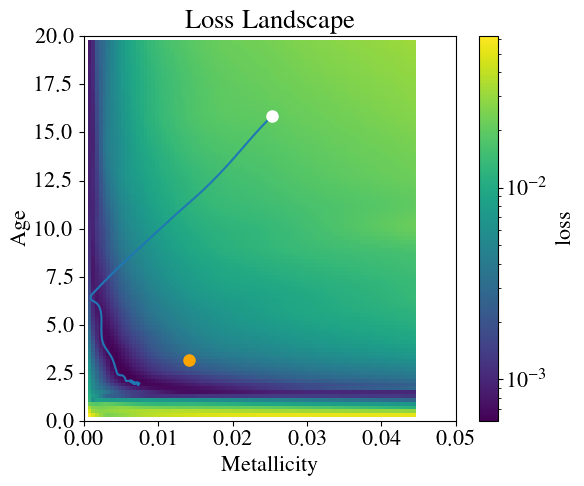

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.figure(figsize=(6, 5))

# Update the extent to the physical values: metallicity from 0 to 0.05 and age from 0 to 20.
plt.imshow(loss_map, origin='lower', extent=[0, 0.05, 0, 20], aspect='auto', norm=colors.LogNorm())

plt.xlabel('Metallicity')
plt.ylabel('Age')
plt.title('Loss Landscape')
plt.colorbar(label='loss')

# Plot the history in physical coordinates by multiplying the normalized values.
plt.plot(metallicity_history[:], age_history[:])#, 'bx', markersize=8)

# Plot the red dots in physical coordinates
plt.plot(metallicity_values[index_metallicity], age_values[index_age], marker='o', color='orange', markersize=8)
plt.plot(metallicity_values[initial_metallicity_index], age_values[initial_age_index], 'wo', markersize=8)

plt.savefig("output/optimisation_losslandscape.jpg", dpi=1000)
plt.show()